In [206]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
import plotly.express as px
import cufflinks as cf
from  plotly.offline import plot

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import classification_report
import collections


In [2]:
# importing class object that I created
import sys  
sys.path.insert(0, '../src/')
import utils

In [3]:
tools = utils.tools() # create object

In [4]:
epi_data_df = tools.readfile('../data/processed/epi_vector.h5')
epi_data_df = tools.df

In [112]:
new_data_df = tools.readfile('../data/processed/recipe_vectors.pickle')

In [114]:
new_data_df = tools.df

In [117]:
new_data_df.tail(1)

,""" 00 "" (soft wheat) flour * or cake flour",""" 00 "" flour",""" 00 "" flour, divide",""" > chicken stock chicken broth",""" > panko (japanese bread crumb bread crumb",""" baby "" Pattypan squash",""" biscuit cutter",""" brown candy "" sugar brown sugar",""" cauliflower floret (cut from 1 large head)",""" circular wire rack",...,ﬁne dry bread crumb,ﬁne salt,avg_rating,best_rating,worst_rating,prepare_again_rating,num_reviews,total_time,tags,title
http://www.epicurious.com/recipes/food/views/zwetschgenkuchen-14600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,4.0,0.0,0.83,6.0,0.0,"[Cake, Fruit, Dessert, Rosh Hashanah/Yom Kippu...",Zwetschgenkuchen


In [8]:
epi_data_df.shape

(34626, 17972)

## Helper functions

In [9]:
epi_data_df.shape


(34626, 17972)

In [10]:
def countTags(sample_df):
    # Get count of tags

    c = Counter()  
    sample_df["tags"].apply(lambda x: c.update(x))
    # store tag count in df
    count = pd.DataFrame()
    count['tags_count'] = [c[i] for i in c]
    count['tag'] = [i for i in c]
    count = count.sort_values(by='tags_count',ascending=False)

    # delete row with value < n
    indexNames = count[ count['tags_count'] <= 30 ].index

    # Delete these row indexes from dataFrame
    count.drop(indexNames , inplace=True)
    return count


In [11]:
def getallergyTags(count):
    # look for ### Free tags
    count['allergy_tags'] = count['tag'].str.endswith('Free')

    allergy_df = count[count['allergy_tags'] == True]
    return allergy_df

In [12]:
# Create column in sample_df for allergy tags
def addallergytoDF(allergy_df,df):
    for i in allergy_df.tag:
        df[i] = [i in tags for tags in df.tags]
    return df

In [13]:
# I manually took out tags that are not recipe ingredients. And clean input. 
# Uncomment below if  cuisine type is needed
def loadCuisineType():
    cuisinetype = pd.read_csv('cuisinetype.txt',header=None)
    cuisinetype = cuisinetype.transpose()
    cuisinetype = np.array(cuisinetype[0])
    cuisinetype = [x.replace('\'','') for x in cuisinetype]
    cuisinetype = [x.replace('[','') for x in cuisinetype]
    cuisinetype = [x.replace(']','') for x in cuisinetype]
    cuisinetype = [x.lstrip() for x in cuisinetype]
    # print(cuisinetype)
    
    # Uncomment below if states are needed

    states = pd.read_csv('states.csv',header=None)
    states = states.transpose()
    states = np.array(states[0])
    states = [x.lstrip() for x in states]
    # print(states)
    
    # Uncomment below if usa_cuisine is needed

    city = pd.read_csv('usa_city.csv',header=None)
    city = city.transpose()
    city = np.array(city[0])
    city = [x.replace('\'','') for x in city]
    city = [x.replace('[','') for x in city]
    city = [x.replace(']','') for x in city]
    city = [x.lstrip() for x in city]
    usa_cuisine =states+city
    # print(usa_cuisine)
    
    non_usa_cuisine = []
    for i in cuisinetype:
        if i not in usa_cuisine:
            non_usa_cuisine.append(i)
    return usa_cuisine,non_usa_cuisine
    

In [163]:
def addCuisinetypesToDF(sample_df,usa_cuisine,non_usa_cuisine):
    tags_value=[]
    for tags in sample_df['tags']:
        if(set(tags).intersection(usa_cuisine)):
            tags_value.append(1)
            continue
        else:
            if(set(tags).intersection(non_usa_cuisine)):
                tags_value.append(0)
            else:
                tags_value.append(2)
    sample_df['usa_cuisine'] = tags_value
    return sample_df

In [164]:
# Drop column with all zeros
def dropZeroColumns(sample_df):
    sample_df = sample_df.loc[:, (sample_df != 0).any(axis=0)]
    return sample_df

In [165]:
def deleterows(df,column,value1,value2,yes):
    if(yes): # deleted row based on two values
        df = df.drop(df[df[column] == value1].index)
        df = df.drop(df[df[column] == value2].index)
    else:
        df = df.drop(df [df[column] == value1].index)
    return df

In [166]:
# drop not relevent columns and drop rest of allergy column except one you are analyzing
def dropColumn(sample_df,col):
#     sample_df = sample_df.drop(columns=['avg_rating','best_rating','prepare_again_rating','num_reviews'],axis=0)
    sample_df = sample_df[(sample_df != np.inf).all(axis=1)]
    sample_df = sample_df.drop(columns=col,axis=1)

    return sample_df

In [167]:

def getTrianData(sample_df,label_column):
    '''Seperate data and label to classify, 
    X are attribute columns used to classify, Y is the label
    first delete all infinity values in data. It also drop columns that are not needed.'''
    data = sample_df.drop(columns=label_column, axis=1)
    label = sample_df[label_column]
    return data,label


In [168]:
class SVCmodel(object):
    def __init__(self):
        pass
    def getSupport(self,model):
        '''Indices of support vectors'''
        return model.support_
    def getClassWeight(self,model):
        '''Support vectors'''
        return model.class_weight_
    def getNsupport(self,model):
        '''# of support vector for each class'''
        return model.n_support_
    def getsupportcoef(self,model):
        '''related to support vector in the decision function.'''
        return model.dual_coef_
    def getfeaturesweight(self,model):
        '''weight assigned to the features'''
        return model.coef_
    def getintercept(self,model):
        '''constants in decision function'''
        return model.intercept_
    def getfitstatus(self,model):
        '''0 if correctly fitted, 1 otherwise(will raise warning)'''
        return model.fit_status_
    def getclasses(self,model):
        '''The class label'''
        return model.classes_
    def getprobA(self,model):
        '''array type, shape = [n_class*(n_classes-1)/2]'''
        return model.probA_
    def getprobB(self,model):
        '''array type, shape = [n_class*(n_classes-1)/2].
        If probability=True, it corresponds to the parameters 
        learned in Platt scaling to produce probability estimates 
        from decision values. If probability=False, it’s an empty array. 
        Platt scaling uses the logistic function 
        1 / (1 + exp(decision_value * probA_ + probB_)) 
        where probA_ and probB_ are learned from the dataset 
        '''
        return model.probA_
    def getclassweight(self,model):
        '''multipliers of parameter C for each class.'''
        return model.class_weight_
    def getshapefit(self,model):
        return model.shape_fit_

## Data Preparation for Classification

In [169]:
# Cuisine Types: usa_cuisine ==> 1, non_usa_cuisine ==> 1, no_tags ==> 2
c = countTags(epi_data_df)
usa_cuisine,non_usa_cuisine = loadCuisineType()
allergy_tags = getallergyTags(c)
sample_df = epi_data_df.head(10000)
sample_df = addCuisinetypesToDF(sample_df,usa_cuisine,non_usa_cuisine)
cuisine_df = sample_df
sample_df = addallergytoDF(allergy_tags,sample_df)
sample_df = dropZeroColumns(sample_df)


In [170]:
sample_df.head(2)

,""" > panko (japanese bread crumb bread crumb",""" biscuit cutter",""" brown candy "" sugar brown sugar",""" cauliflower floret (cut from 1 large head)",""" cube salt pork",""" large "" egg",""" pie dish",""" piece (about 6 ounce) thick - cut smoke bacon",""" piece ginger, peel, finely grated",""" pita bread",...,num_reviews,tags,title,usa_cuisine,Peanut Free,Soy Free,Tree Nut Free,Wheat/Gluten-Free,Dairy Free,Fat Free
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.0,"[Cheese, Vegetable, No-Cook, Vegetarian, Quick...","""Adult"" Pimiento Cheese",1,False,False,False,False,False,False
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,"[Ginger, Dessert, Bake, Apple, Almond, Fall, R...","""An Apple a Day""",2,True,True,False,False,False,False


In [276]:
# c[c['tag'] == 'Peanut']

In [275]:
# c[c['tag'] == 'Summer']
# c[c['tag'] == 'Winter']
# c[c['tag'] == 'Fall']
# c[c['tag'] == 'Spring']


In [277]:
def addSeasontypesToDF(sample_df,season,label):
    tags_value=[]
    print(season[0])
    for tags in sample_df['tags']:
        if(season[0] in set(tags)): #spring
            tags_value.append(1)
        elif(season[1] in set(tags)): #summer
            tags_value.append(2)
        elif(season[2] in set(tags)): #fall
            tags_value.append(3)
        elif(season[3] in set(tags)): #winter
            tags_value.append(4)
        else:
            tags_value.append(0) # for non-season food
    sample_df[label] = tags_value
    return sample_df

In [279]:
addSeasontypesToDF(sample_df,['Spring','Summer','Fall','Winter'],'season').head()

Spring


,""" > panko (japanese bread crumb bread crumb",""" biscuit cutter",""" brown candy "" sugar brown sugar",""" cauliflower floret (cut from 1 large head)",""" cube salt pork",""" large "" egg",""" pie dish",""" piece (about 6 ounce) thick - cut smoke bacon",""" piece ginger, peel, finely grated",""" pita bread",...,tags,title,usa_cuisine,Peanut Free,Soy Free,Tree Nut Free,Wheat/Gluten-Free,Dairy Free,Fat Free,season
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,"[Cheese, Vegetable, No-Cook, Vegetarian, Quick...","""Adult"" Pimiento Cheese",1,False,False,False,False,False,False,4
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,"[Ginger, Dessert, Bake, Apple, Almond, Fall, R...","""An Apple a Day""",2,True,True,False,False,False,False,3
http://www.epicurious.com/recipes/food/views/-blanketed-eggplant-305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,"[Tomato, Vegetable, Appetizer, Side, Vegetaria...","""Blanketed"" Eggplant",2,False,False,False,False,False,False,0
http://www.epicurious.com/recipes/food/views/-bloody-mary-tomato-toast-with-celery-and-horseradish-56389813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,"[Condiment/Spread, Tomato, Appetizer, Kid-Frie...","""Bloody Mary"" Tomato Toast with Celery and Hor...",2,True,True,True,False,True,False,1
http://www.epicurious.com/recipes/food/views/-bow-tie-pasta-with-zucchini-101932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,"[Pasta, Vegetarian, Quick & Easy, Dinner, Basi...","""Bow-Tie"" Pasta with Zucchini",2,True,True,True,False,False,False,2


In [281]:
c = Counter()
c.update(sample_df.season)
c

Counter({4: 1084, 3: 1518, 0: 5098, 1: 700, 2: 1600})

In [282]:
sample_df.shape

(10000, 7313)

In [283]:
spring = []
summer = []
fall = []
winter =[]
spring_df = sample_df.tags[sample_df['season']==1].values
summer_df = sample_df.tags[sample_df['season']==2].values
fall_df = sample_df.tags[sample_df['season']==3].values
winter_df = sample_df.tags[sample_df['season']==4].values

In [302]:
s = Counter()
tags_list = []
count = 0
for tags in sample_df['tags']:
    if('Peanut' in tags):
#         print(tags)
        count +=1
        for i in tags:
            tags_list.append(i)

print("Tags list Containing Peanut Ingredient, but not Peanut Free tag",count)
s.update(tags_list)
s.most_common(10)

Tags list Containing Peanut Ingredient, but not Peanut Free tag 89


[('Peanut', 89),
 ('Tree Nut Free', 52),
 ('Soy Free', 45),
 ('Vegetarian', 45),
 ('Kosher', 42),
 ('Bon Appétit', 40),
 ('Pescatarian', 38),
 ('Dessert', 36),
 ('Gourmet', 31),
 ('Bake', 28)]

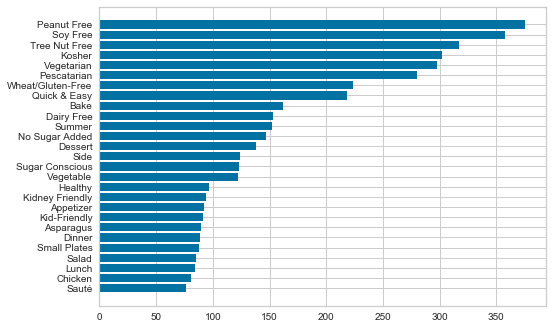

In [303]:
s = Counter()
for i in range(len(spring_df)):
    s.update(spring_df[i])
s = [i for i in s.most_common(30) if(i[0] != 'Spring' and i[0] !='Gourmet' and "Bon App" not in i[0])]
keys = [x[0] for x in s]
values = [x[1] for x in s]
plt.barh(keys[::-1],values[::-1])
plt.show()

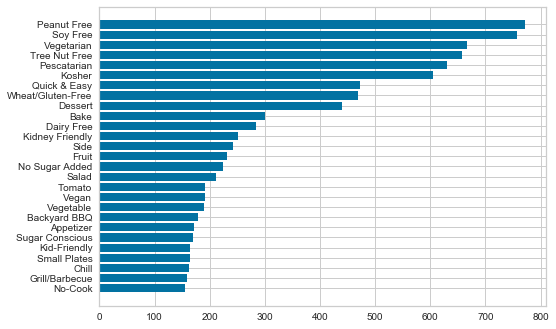

In [306]:
su = Counter()
for i in range(len(summer_df)):
    su.update(summer_df[i])
su = [i for i in su.most_common(30) if(i[0] != 'Summer' and i[0] !='Gourmet' and "Bon App" not in i[0])]
keys = [x[0] for x in su]
values = [x[1] for x in su]
plt.barh(keys[::-1],values[::-1])
plt.show()

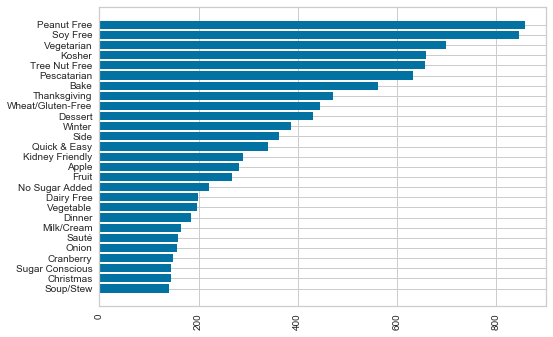

In [273]:
f = Counter()
for i in range(len(fall_df)):
    f.update(fall_df[i])
f = [i for i in f.most_common(30) if(i[0] != 'Fall' and i[0] !='Gourmet' and "Bon App" not in i[0])]
keys = [x[0] for x in f]
values = [x[1] for x in f]
plt.barh(keys[::-1],values[::-1])
plt.xticks(rotation=90)
plt.show()

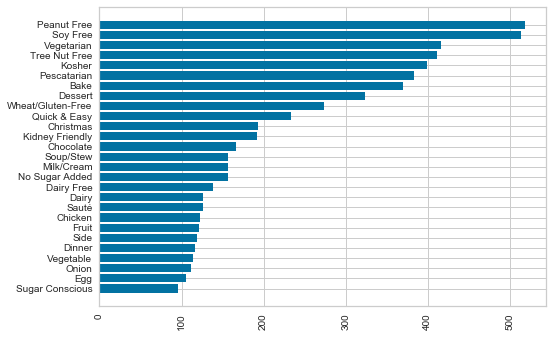

In [274]:
w = Counter()
for i in range(len(winter_df)):
    w.update(winter_df[i])
w = [i for i in w.most_common(30) if(i[0] != 'Winter' and i[0] !='Gourmet' and "Bon App" not in i[0])]
keys = [x[0] for x in w]
values = [x[1] for x in w]
plt.barh(keys[::-1],values[::-1])
plt.xticks(rotation=90)
plt.show()

In [135]:
# for i in sample_df.tags:
#     for j in i:
#         if(j == 'Peanut'):
#             print(i)

In [129]:
n = sample_df['tags'].str.contains('Peanut').values
print(len(np.isnan(n)))
len(n)

10000


10000

### Plot Correlation for Allergy Features

In [21]:
# sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
#             cmap=sns.diverging_palette(220, 10, as_cmap=True))

In [22]:
sample_df.shape

(10000, 7312)

In [23]:
allergy = ['Peanut Free','Soy Free','Tree Nut Free','Wheat/Gluten-Free','Dairy Free','Fat Free','usa_cuisine']
sample_df[allergy] *= 1
sample_df.head(1)

,""" > panko (japanese bread crumb bread crumb",""" biscuit cutter",""" brown candy "" sugar brown sugar",""" cauliflower floret (cut from 1 large head)",""" cube salt pork",""" large "" egg",""" pie dish",""" piece (about 6 ounce) thick - cut smoke bacon",""" piece ginger, peel, finely grated",""" pita bread",...,num_reviews,tags,title,usa_cuisine,Peanut Free,Soy Free,Tree Nut Free,Wheat/Gluten-Free,Dairy Free,Fat Free
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.0,"[Cheese, Vegetable, No-Cook, Vegetarian, Quick...","""Adult"" Pimiento Cheese",1,0,0,0,0,0,0


In [24]:
allergy_corr_df = sample_df[allergy]

In [25]:
allergy_corr_df.corr()

,Peanut Free,Soy Free,Tree Nut Free,Wheat/Gluten-Free,Dairy Free,Fat Free,usa_cuisine
Peanut Free,1.000000,0.936212,0.791655,0.505269,0.385601,0.135089,0.036579
Soy Free,0.936212,1.000000,0.770314,0.522209,0.330559,0.134076,0.043605
Tree Nut Free,0.791655,0.770314,1.000000,0.459500,0.408854,0.160164,0.042681
Wheat/Gluten-Free,0.505269,0.522209,0.459500,1.000000,0.412612,0.199519,0.023238
Dairy Free,0.385601,0.330559,0.408854,0.412612,1.000000,0.314115,0.002851
Fat Free,0.135089,0.134076,0.160164,0.199519,0.314115,1.000000,0.020198
usa_cuisine,0.036579,0.043605,0.042681,0.023238,0.002851,0.020198,1.000000


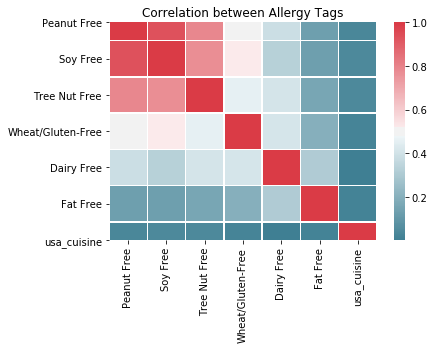

In [27]:
sns.heatmap(allergy_corr_df.corr(),xticklabels=allergy_corr_df.columns,yticklabels=allergy_corr_df.columns,linewidth=.5,cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.title("Correlation between Allergy Tags")
plt.show()

In [28]:
reviews = ['avg_rating','best_rating','prepare_again_rating','num_reviews']
review_df = sample_df[reviews].dropna()
review_df = review_df[review_df.columns].astype(float)


In [29]:
review_df.corr()

,avg_rating,best_rating,prepare_again_rating,num_reviews
avg_rating,1.000000,0.083938,0.819613,0.227283
best_rating,0.083938,1.000000,0.074258,0.016596
prepare_again_rating,0.819613,0.074258,1.000000,0.218849
num_reviews,0.227283,0.016596,0.218849,1.000000


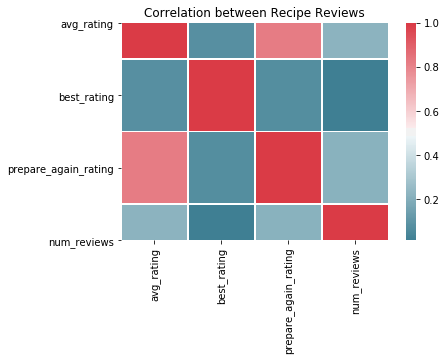

In [30]:
sns.heatmap(review_df.corr(),xticklabels=review_df.columns,yticklabels=review_df.columns,linewidth=.5,cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.title("Correlation between Recipe Reviews")
plt.show()

In [31]:
sample_df[allergy].shape

(10000, 7)

In [32]:
sample_df[allergy].apply(pd.value_counts)

,Peanut Free,Soy Free,Tree Nut Free,Wheat/Gluten-Free,Dairy Free,Fat Free,usa_cuisine
0,5019.0,5127.0,5928.0,7288.0,8410.0,9792.0,115
1,4981.0,4873.0,4072.0,2712.0,1590.0,208.0,348
2,NaN,NaN,NaN,NaN,NaN,NaN,9537


In [33]:
# sample_df[allergy][(sample_df['Peanut Free'] == 1) & (sample_df['usa_cuisine'] == 1)].shape

In [34]:
for i in allergy[:-1]:
    print(i)

Peanut Free
Soy Free
Tree Nut Free
Wheat/Gluten-Free
Dairy Free
Fat Free


In [35]:
copy = sample_df[allergy]
copy.head()

,Peanut Free,Soy Free,Tree Nut Free,Wheat/Gluten-Free,Dairy Free,Fat Free,usa_cuisine
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0,0,0,0,0,0,1
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,1,1,0,0,0,0,2
http://www.epicurious.com/recipes/food/views/-blanketed-eggplant-305,0,0,0,0,0,0,2
http://www.epicurious.com/recipes/food/views/-bloody-mary-tomato-toast-with-celery-and-horseradish-56389813,1,1,1,0,1,0,2
http://www.epicurious.com/recipes/food/views/-bow-tie-pasta-with-zucchini-101932,1,1,1,0,0,0,2


In [36]:
copy = copy[(copy['usa_cuisine'] != 2)]

In [37]:
def plotgraph(df,title,x):
    df.plot.hist(x=x,y='usa_cuisine',figsize=(5,5),grid=True)
    plt.title(title)
    plt.xlabel('usa_cuisine')
    plt.ylabel(x)
    

In [38]:
c.head()

,tags_count,tag,allergy_tags
19,16546,Peanut Free,True
20,16106,Soy Free,True
17,15226,Bon Appétit,False
34,14030,Tree Nut Free,True
3,13382,Vegetarian,False


In [39]:
c[c['allergy_tags']==True]

,tags_count,tag,allergy_tags
19,16546,Peanut Free,True
20,16106,Soy Free,True
34,14030,Tree Nut Free,True
57,9581,Wheat/Gluten-Free,True
33,6020,Dairy Free,True
288,681,Fat Free,True


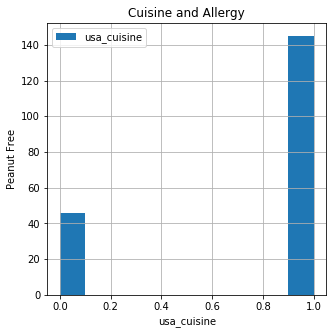

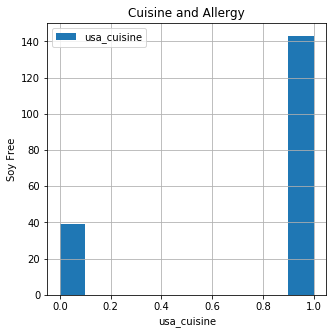

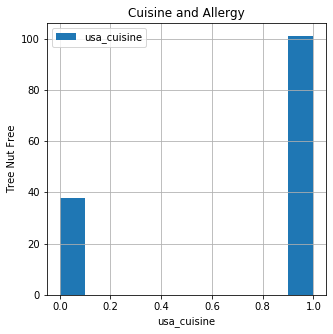

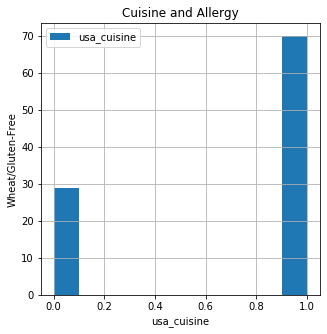

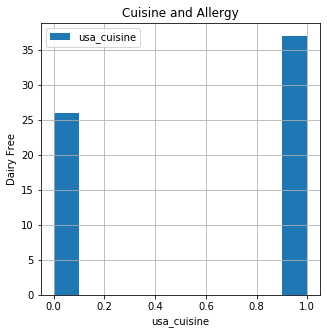

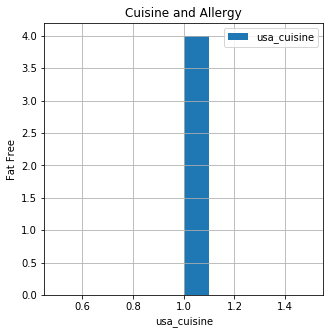

In [40]:
# copy = dropColumn(copy,['avg_rating','best_rating','prepare_again_rating','num_reviews','tags','title'])
# print(copy.shape)
for i in allergy[:-1]:
    allergy_df = copy[(copy[i] == 1)]
    allergy_df = allergy_df[['usa_cuisine',i]]
#     print(allergy_df.head())
#     print(allergy_df.shape)
    plotgraph(allergy_df,'Cuisine and Allergy',i)
    


In [41]:
copy.head()

,Peanut Free,Soy Free,Tree Nut Free,Wheat/Gluten-Free,Dairy Free,Fat Free,usa_cuisine
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0,0,0,0,0,0,1
http://www.epicurious.com/recipes/food/views/-drunken-pork-chops-427,0,0,0,1,0,0,0
http://www.epicurious.com/recipes/food/views/-em-polow-em-persian-rice-with-pistachios-and-dill-352469,1,1,0,1,0,0,0
http://www.epicurious.com/recipes/food/views/-opulent-chicken-15810,0,0,0,0,0,0,1
http://www.epicurious.com/recipes/food/views/a-nineties-twist-to-a-grandmothers-roast-chicken-102023,0,0,0,0,0,0,0


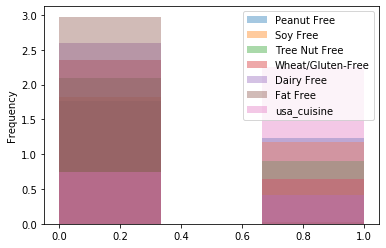

In [42]:
copy.plot.hist(alpha=0.4,density=True,bins=3)
plt.show()

### Deletes Not used columns

In [43]:
drop_column = ['avg_rating','best_rating','prepare_again_rating','num_reviews','usa_cuisine','tags','title']
label_column = ['Peanut Free','Soy Free','Tree Nut Free','Wheat/Gluten-Free','Dairy Free','Fat Free']

# copy1 = sample_df
# copy2 = sample_df
# usa_tag_df = deleterows(copy1,'usa_cuisine',2,'',True)
# no_cuisine_tag_df = deleterows(copy2,'usa_cuisine',1,0,False)


In [44]:
sample_df = dropColumn(sample_df,drop_column)

In [45]:
sample_df.head(1)

,""" > panko (japanese bread crumb bread crumb",""" biscuit cutter",""" brown candy "" sugar brown sugar",""" cauliflower floret (cut from 1 large head)",""" cube salt pork",""" large "" egg",""" pie dish",""" piece (about 6 ounce) thick - cut smoke bacon",""" piece ginger, peel, finely grated",""" pita bread",...,zucchini squash,zucchini zucchini,"zucchini, quarter lengthwise then slice across thinly",zucchinis,Peanut Free,Soy Free,Tree Nut Free,Wheat/Gluten-Free,Dairy Free,Fat Free
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0


In [46]:
# usa_tag_df

In [47]:
training_data,test_data = train_test_split(sample_df,test_size= 0.2)
train_data,train_label = getTrianData(training_data,label_column)
test_data,test_label = getTrianData(test_data,label_column)

In [48]:
# train_data,train_label = getTrianData(training_data,label_column)
# test_data,test_label = getTrianData(test_data,label_column)

In [49]:
training_data.head(2)

,""" > panko (japanese bread crumb bread crumb",""" biscuit cutter",""" brown candy "" sugar brown sugar",""" cauliflower floret (cut from 1 large head)",""" cube salt pork",""" large "" egg",""" pie dish",""" piece (about 6 ounce) thick - cut smoke bacon",""" piece ginger, peel, finely grated",""" pita bread",...,zucchini squash,zucchini zucchini,"zucchini, quarter lengthwise then slice across thinly",zucchinis,Peanut Free,Soy Free,Tree Nut Free,Wheat/Gluten-Free,Dairy Free,Fat Free
http://www.epicurious.com/recipes/food/views/cider-and-calvados-gelees-with-champagne-grapes-14476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,1,1,1,1,1
http://www.epicurious.com/recipes/food/views/antipasto-salad,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0


In [50]:
train_label.head(2)

,Peanut Free,Soy Free,Tree Nut Free,Wheat/Gluten-Free,Dairy Free,Fat Free
http://www.epicurious.com/recipes/food/views/cider-and-calvados-gelees-with-champagne-grapes-14476,1,1,1,1,1,1
http://www.epicurious.com/recipes/food/views/antipasto-salad,0,0,0,0,0,0


In [51]:
train_data.head(2)

,""" > panko (japanese bread crumb bread crumb",""" biscuit cutter",""" brown candy "" sugar brown sugar",""" cauliflower floret (cut from 1 large head)",""" cube salt pork",""" large "" egg",""" pie dish",""" piece (about 6 ounce) thick - cut smoke bacon",""" piece ginger, peel, finely grated",""" pita bread",...,ziti pasta,zucchini,"zucchini (about 5 medium), slice thin",zucchini blossom,"zucchini blossom, tear into large piece (optional)",zucchini flower,zucchini squash,zucchini zucchini,"zucchini, quarter lengthwise then slice across thinly",zucchinis
http://www.epicurious.com/recipes/food/views/cider-and-calvados-gelees-with-champagne-grapes-14476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://www.epicurious.com/recipes/food/views/antipasto-salad,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Support Vector Classifier

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

Below website gives good explaination on reading result from SVC

https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python

### Fit model without weights

Referenced example from this link: https://www.geeksforgeeks.org/classifying-data-using-support-vector-machinessvms-in-python/

In [52]:
svc = svm.SVC(gamma=0.1,kernel='linear')

In [53]:
train_label.head(1)

,Peanut Free,Soy Free,Tree Nut Free,Wheat/Gluten-Free,Dairy Free,Fat Free
http://www.epicurious.com/recipes/food/views/cider-and-calvados-gelees-with-champagne-grapes-14476,1,1,1,1,1,1


In [54]:
new_labels = np.asarray(train_label.values)
new_labels

array([[1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 0, 0],
       [0, 0, 0, 1, 0, 0]])

In [55]:
train_data.shape

(7988, 7299)

In [56]:
len(train_label)

7988

In [58]:
train_size = 1000

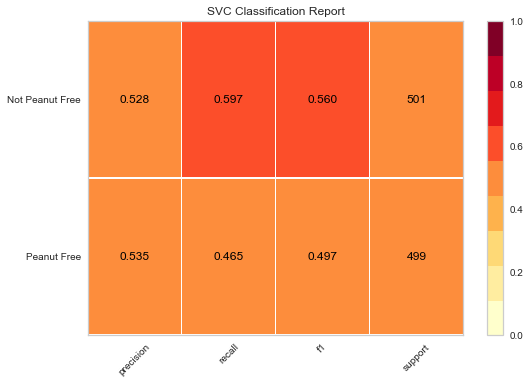

CPU times: user 50.7 s, sys: 481 ms, total: 51.2 s
Wall time: 56.3 s


In [57]:
%%time
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(svc, classes=['Peanut Free','Not Peanut Free'], support=True)
visualizer.fit(train_data.iloc[:train_size], train_label['Peanut Free'].iloc[:train_size])        # Fit the visualizer and the model
visualizer.score(test_data.iloc[:train_size], test_label['Peanut Free'].iloc[:train_size])        # Evaluate the model on the test data
visualizer.show() 

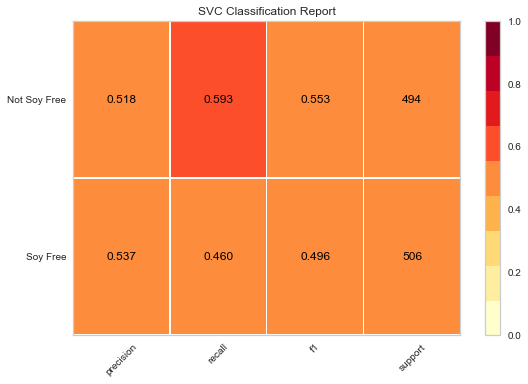

CPU times: user 11.9 s, sys: 98.3 ms, total: 12 s
Wall time: 12.4 s


In [61]:
%%time
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(svc, classes=['Soy Free','Not Soy Free'], support=True)
visualizer.fit(train_data.iloc[:train_size], train_label['Soy Free'].iloc[:train_size])        # Fit the visualizer and the model
visualizer.score(test_data.iloc[:train_size], test_label['Soy Free'].iloc[:train_size])        # Evaluate the model on the test data
visualizer.show() 

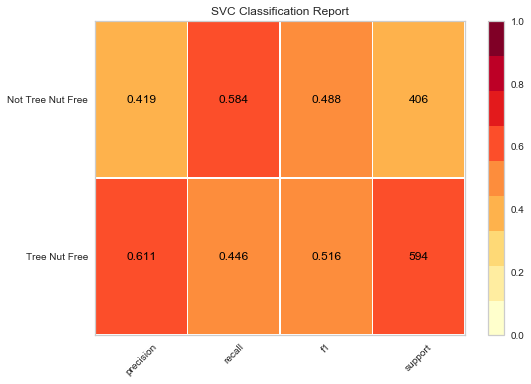

CPU times: user 12.1 s, sys: 90.8 ms, total: 12.2 s
Wall time: 14.3 s


In [62]:
%%time
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(svc, classes=['Tree Nut Free','Not Tree Nut Free'], support=True)
visualizer.fit(train_data.iloc[:train_size], train_label['Tree Nut Free'].iloc[:train_size])        # Fit the visualizer and the model
visualizer.score(test_data.iloc[:train_size], test_label['Tree Nut Free'].iloc[:train_size])        # Evaluate the model on the test data
visualizer.show() 

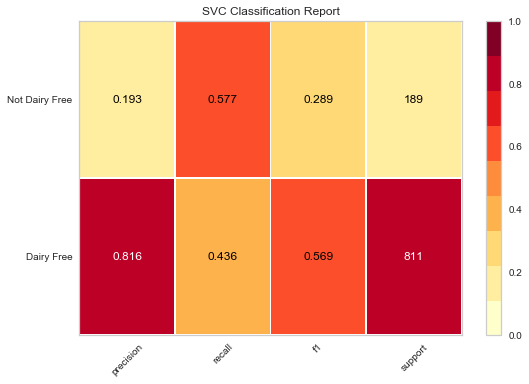

CPU times: user 11.9 s, sys: 89.1 ms, total: 12 s
Wall time: 12.7 s


In [63]:
%%time
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(svc, classes=['Dairy Free','Not Dairy Free'], support=True)
visualizer.fit(train_data.iloc[:train_size], train_label['Dairy Free'].iloc[:train_size])        # Fit the visualizer and the model
visualizer.score(test_data.iloc[:train_size], test_label['Dairy Free'].iloc[:train_size])        # Evaluate the model on the test data
visualizer.show() 

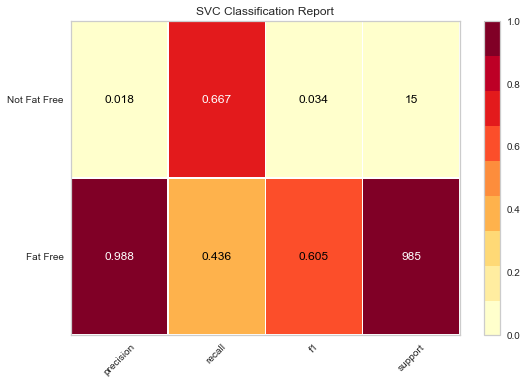

CPU times: user 11.8 s, sys: 65.5 ms, total: 11.8 s
Wall time: 12.2 s


In [64]:
%%time
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(svc, classes=['Fat Free','Not Fat Free'], support=True)
visualizer.fit(train_data.iloc[:train_size], train_label['Fat Free'].iloc[:train_size])        # Fit the visualizer and the model
visualizer.score(test_data.iloc[:train_size], test_label['Fat Free'].iloc[:train_size])        # Evaluate the model on the test data
visualizer.show() 

In [50]:
%%time
peanut.predict(test_data)

CPU times: user 34.4 s, sys: 143 ms, total: 34.6 s
Wall time: 35 s


array([1, 0, 0, ..., 1, 0, 0])

In [65]:
# val = []
# for i in train_label:
#     v = i.replace(' ','')
#     val.append(v)
# val

In [52]:
# allergy_predict = []
# j = 0
# for i in train_label:
#     print(val[j])
#     val[j] = svc.fit(train_data.iloc[:train_size], np.asarray(train_label[i].iloc[:train_size].values)) 
#     allergy_predict.append(val[j])
#     j +=1
# allergy_predict

### Fit model with weights

#### Calculate Weight

* sample_weight is to be applied to individual samples (rows in your data). So the length of sample_weight must match the number of samples in your X.

* class_weight is to make the classifier give more importance and attention to the classes. So the length of class_weight must match the number of classes in your targets.

In [66]:
count1 = len(cuisine_df.loc[cuisine_df['usa_cuisine'] == 1]) # true
count2 = len(cuisine_df.loc[cuisine_df['usa_cuisine'] == 0]) # false
count3 = len(cuisine_df.loc[cuisine_df['usa_cuisine'] == 2]) # NA
print("Neither USA Cuisine or non-USA Cuisine: ",count3)
print("USA Cuisine: ",count1)
print("Non-USA Cuisine: ",count2)

Neither USA Cuisine or non-USA Cuisine:  9537
USA Cuisine:  348
Non-USA Cuisine:  115


In [67]:
print(len(train_label))

7988


In [73]:
weight_ratio = []
for i in train_label:
    max_v = [int(train_label[i][train_label[i] == 0].value_counts())/len(train_label),int(train_label[i][train_label[i] == 1].value_counts())/len(train_label)]
    print(max_v)
    weight_ratio.append(max_v)
weight_ratio

[0.5011266900350526, 0.49887330996494744]
[0.5120180270405609, 0.4879819729594392]
[0.592764146219329, 0.407235853780671]
[0.7282173259889835, 0.2717826740110165]
[0.8466449674511768, 0.15335503254882324]
[0.979594391587381, 0.020405608412618927]


[[0.5011266900350526, 0.49887330996494744],
 [0.5120180270405609, 0.4879819729594392],
 [0.592764146219329, 0.407235853780671],
 [0.7282173259889835, 0.2717826740110165],
 [0.8466449674511768, 0.15335503254882324],
 [0.979594391587381, 0.020405608412618927]]

In [74]:
weight_ratio[0][0]

0.5011266900350526

In [75]:
degree = [1, 1, 2, 3, 4, 1, 1, 1, 1, 2, 3, 4, 1, 1, 1, 1, 2]
degree
kernel =['linear', 'poly', 'poly', 'poly', 'poly', 'rbf', 'sigmoid',
        'linear', 'poly', 'poly', 'poly', 'poly', 'rbf', 'sigmoid',
        'linear', 'poly', 'poly']
nu = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.1 , 0.1 , 0.1 , 0.1 ,
        0.1 , 0.1 , 0.1 , 0.15, 0.15, 0.15]
acc_list = [0.90653153, 0.90728228, 0.61473974, 0.56681682, 0.53440941,
        0.75525526, 0.50287788, 0.90840841, 0.90578078, 0.60047548,
        0.56881882, 0.53553554, 0.75575576, 0.5289039 , 0.90515516,
        0.90302803, 0.5701952 ]
# degree,kernel,nu,acc_list

In [76]:
import mplcursors

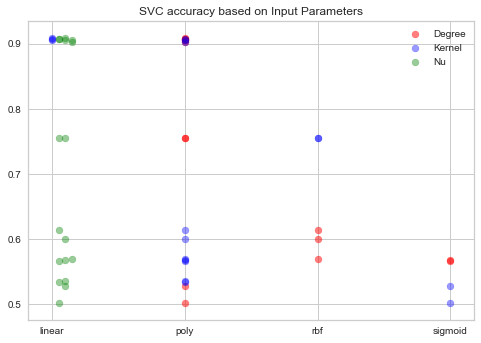

In [77]:
plt.scatter(degree,acc_list,alpha=0.5,color='red',label='Degree')
plt.scatter(kernel,acc_list,alpha=0.4,color='blue',label='Kernel')
plt.scatter(nu,acc_list,alpha=0.4,color='green',label='Nu')
plt.legend()
mplcursors.cursor(hover=True)
plt.title("SVC accuracy based on Input Parameters")
plt.show()

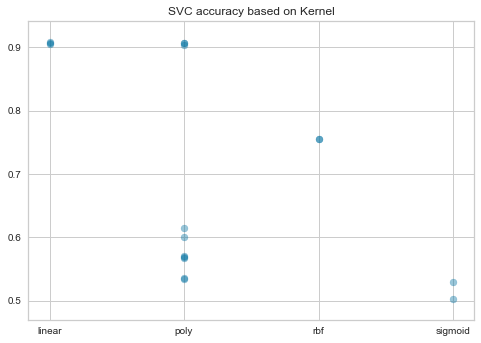

In [78]:
plt.scatter(kernel,acc_list,alpha=0.4)
plt.title("SVC accuracy based on Kernel")
plt.show()

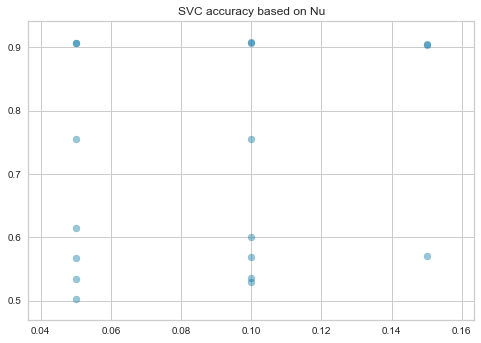

In [79]:
plt.scatter(nu,acc_list,alpha=0.4)
plt.title("SVC accuracy based on Nu")
plt.show()

## Single Class Classification

In [ ]:
train_size

In [80]:
%%time
w_svc = svm.NuSVC(nu = 0.1, gamma='auto',class_weight={0:weight_ratio[0][0]},kernel='linear')
w_svc.fit(train_data.iloc[:train_size], train_label['Peanut Free'][:train_size])#,sample_weight=cal_w) 

CPU times: user 51.4 s, sys: 413 ms, total: 51.8 s
Wall time: 59.2 s


NuSVC(cache_size=200, class_weight={0: 0.5011266900350526}, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
      max_iter=-1, nu=0.1, probability=False, random_state=None, shrinking=True,
      tol=0.001, verbose=False)

In [ ]:
test_data.head()

In [84]:
train_size = 1000

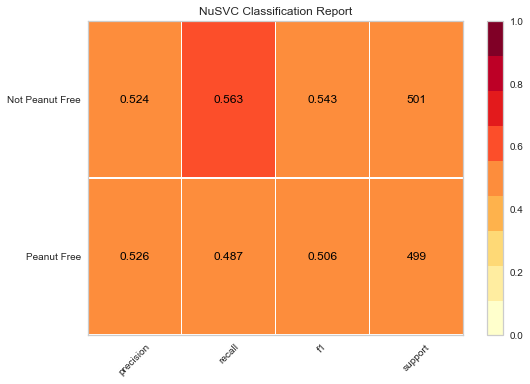

CPU times: user 11.6 s, sys: 126 ms, total: 11.7 s
Wall time: 12.7 s


In [85]:
%%time
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(w_svc, classes=['Peanut Free','Not Peanut Free'], support=True)
visualizer.fit(train_data.iloc[:train_size], train_label['Peanut Free'].iloc[:train_size])        # Fit the visualizer and the model
visualizer.score(test_data.iloc[:train_size], test_label['Peanut Free'].iloc[:train_size])        # Evaluate the model on the test data
visualizer.show() 

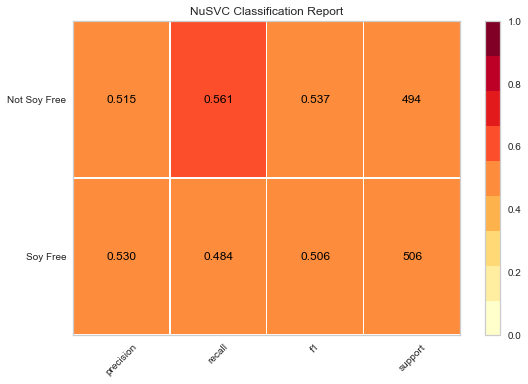

CPU times: user 11.5 s, sys: 87.4 ms, total: 11.5 s
Wall time: 12.7 s


In [86]:
%%time
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(w_svc, classes=['Soy Free','Not Soy Free'], support=True)
visualizer.fit(train_data.iloc[:train_size], train_label['Soy Free'].iloc[:train_size])        # Fit the visualizer and the model
visualizer.score(test_data.iloc[:train_size], test_label['Soy Free'].iloc[:train_size])        # Evaluate the model on the test data
visualizer.show() 

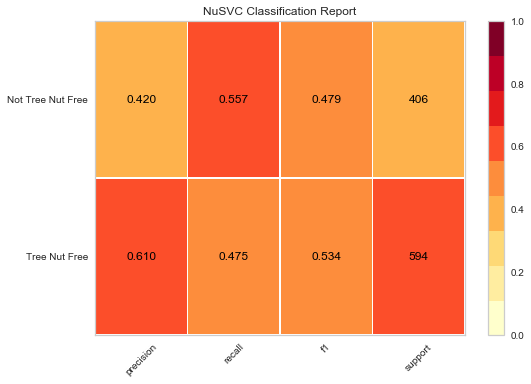

CPU times: user 11.8 s, sys: 98.6 ms, total: 11.9 s
Wall time: 13.7 s


In [87]:
%%time
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(w_svc, classes=['Tree Nut Free','Not Tree Nut Free'], support=True)
visualizer.fit(train_data.iloc[:train_size], train_label['Tree Nut Free'].iloc[:train_size])        # Fit the visualizer and the model
visualizer.score(test_data.iloc[:train_size], test_label['Tree Nut Free'].iloc[:train_size])        # Evaluate the model on the test data
visualizer.show() 

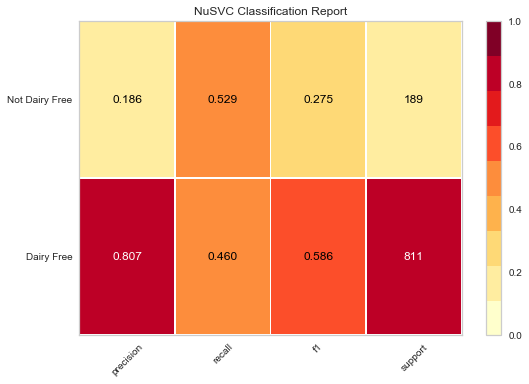

CPU times: user 11.7 s, sys: 108 ms, total: 11.8 s
Wall time: 13.5 s


In [88]:
%%time
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(w_svc, classes=['Dairy Free','Not Dairy Free'], support=True)
visualizer.fit(train_data.iloc[:train_size], train_label['Dairy Free'].iloc[:train_size])        # Fit the visualizer and the model
visualizer.score(test_data.iloc[:train_size], test_label['Dairy Free'].iloc[:train_size])        # Evaluate the model on the test data
visualizer.show() 

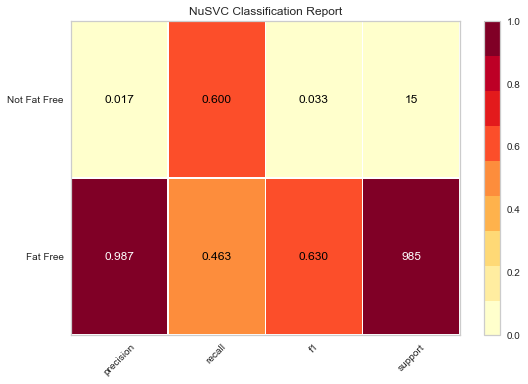

CPU times: user 12.2 s, sys: 127 ms, total: 12.3 s
Wall time: 15.8 s


In [89]:
%%time
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(w_svc, classes=['Fat Free','Not Fat Free'], support=True)
visualizer.fit(train_data.iloc[:train_size], train_label['Fat Free'].iloc[:train_size])        # Fit the visualizer and the model
visualizer.score(test_data.iloc[:train_size], test_label['Fat Free'].iloc[:train_size])        # Evaluate the model on the test data
visualizer.show() 

In [91]:
%%time
p = w_svc.predict(test_data)

CPU times: user 11.3 s, sys: 165 ms, total: 11.5 s
Wall time: 13.2 s


array([0, 1, 1, ..., 0, 1, 0])

In [95]:
from sklearn.metrics import classification_report

print(classification_report(test_label['Peanut Free'],p))

              precision    recall  f1-score   support

           0       0.52      0.48      0.50      1009
           1       0.51      0.55      0.53       989

    accuracy                           0.52      1998
   macro avg       0.52      0.52      0.52      1998
weighted avg       0.52      0.52      0.52      1998



In [98]:
c = Counter()
c.update(test_label['Peanut Free'])
print("actual label count",c)

actual label count Counter({0: 1009, 1: 989})


In [99]:
c = Counter()
c.update(p)
print("prediction label count ",c)

prediction label count  Counter({1: 1065, 0: 933})


## Naive Bayes Classifier

In [102]:
# # create a guassian classifier
bayes_model = GaussianNB()
bayes_model.fit(train_data,train_label['Peanut Free'])
print(bayes_model.epsilon_)

7.741424978497854e-06


In [103]:
p = bayes_model.predict(test_data)

In [105]:
print(classification_report(test_label['Peanut Free'],p))

              precision    recall  f1-score   support

           0       0.64      0.34      0.44      1009
           1       0.54      0.81      0.65       989

    accuracy                           0.57      1998
   macro avg       0.59      0.57      0.55      1998
weighted avg       0.59      0.57      0.54      1998



In [107]:
c = Counter()
c.update(test_label['Peanut Free'])
print("actual label count",c)

actual label count Counter({0: 1009, 1: 989})


In [108]:
c = Counter()
c.update(bayes_model.predict(test_data))
print("prediction label count ",c)

prediction label count  Counter({1: 1467, 0: 531})


Example of computing class_weight

https://programtalk.com/python-examples/sklearn.utils.class_weight.compute_class_weight/

In [63]:
# %%time 
# best_nu = -1
# best_acc = -1
# best_degree = -1
# best_kernel = ''
# w = -1

# nu = []
# degree = []
# kernel = []
# acc_list = []
# for n in range(1,9):
#     nu_v = 0.1*n
#     w += 1
#     for k in ["linear", "poly", "rbf", "sigmoid"]:
#         for d in range(1,10):
#             avg_acc = 0
#             for i in range(10):
#                 training_data,test_data = train_test_split(sample_df,test_size= 0.2)
#                 train_data,train_label = getTrianData(training_data,label_column[0])
#                 test_data,test_label = getTrianData(test_data,label_column[0])
# #                 new_labels = np.asarray(train_label.values)
# #                 c = Counter()
# #                 c.update(new_labels)
# #                       #degree_v = 0.05*i
#                 w_svc = svm.NuSVC(nu = nu_v, kernel=k, gamma='auto',degree = d, class_weight={0:weight_ratio[0][0]},probability=True)
# #                 print("fitting model")
#                 w_svc.fit(train_data.iloc[:train_size], train_label.iloc[:train_size])#,sample_weight=cal_w) 
# #                 print("predicting now")
#                 y_pred = w_svc.predict(test_data)
#                 acc = 0
#                 for idx, val in enumerate(y_pred):
#                     #print(test_label)
#                     if val == test_label.values[idx]:
#                         acc += 1
#                 acc /= len(y_pred)
#                 avg_acc += acc
#                 print('{}: {}'.format(i,acc))
#             avg_acc /= 4
#             print('Kernel: {}, nu: {}, Degree: {} , Avg Acc: {} '.format(k,nu_v, d, avg_acc))
#             if avg_acc > best_acc:
#                 degree.append(d)
#                 kernel.append(k)
#                 nu.append(nu_v)
#                 acc_list.append(avg_acc)
#             if k != "poly":
#                 break

                

In [71]:
# svc_para = pd.DataFrame()
# svc_para['best_degree'] = degree
# svc_para['best_kernel'] = kernel
# svc_para['best_nu'] = nu
# svc_para['best_acc'] = acc_list

In [72]:
# svc_para

In [ ]:
# # gca stands for 'get current axis'
# ax = plt.gca()

# svc_para.plot(kind='line',x='best_acc',y='best_degree',ax=ax)
# # svc_para.plot(kind='line',x='best_acc',y='best_kernel', color='red', ax=ax)
# svc_para.plot(kind='line',x='best_acc',y='best_nu', color='yellow', ax=ax)

# plt.show()

In [ ]:
# svc_para.plot.bar(x=['best_acc'],y=['best_degree','best_kernel','best_nu'],alpha=0.4)
# plt.title("SVC accuracy based on Nu")
# plt.show()

## Not Used Code

In [ ]:
# uncomment below lines to replace column with number greater than 0 to 1 to make it binary.
# columns = ['avg_rating','best_rating','worst_rating','prepare_again_rating','num_reviews','total_time', 'tags', 'title']
# df = sample_df.copy()
# for col in sample_df.columns:
#     if col not in columns:
#         df.loc[df[col] > 0, col] = 1
# df.head(25)

In [ ]:
# len(sample_df[["Breakfast" in x for x in sample_df.tags]])

In [ ]:
# Uncomment below if need to encode data into unique value 


# from sklearn import preprocessing
# # label encoder
# le = preprocessing.LabelEncoder()

# # Converting string labels into numbers
# label = le.fit_transform(Y) # 0 ==> False, 1 ==> True
# label

# Uncomment below if need to convert X data into encoder and turn it into tuple list
#data.apply(le.fit_transform)
#data = [tuple(r) for r in data.values.tolist()]

In [ ]:
# uncomment below if need to look for inf value in data 
# for col in X.columns:
#     print(X.loc[X[col] > 100000, col])

### Example from Sklearn Website

https://scikit-learn.org/stable/auto_examples/svm/plot_weighted_samples.html

In [ ]:
print(__doc__)

def plot_decision_function(classifier, sample_weight, axis, title):
    # plot the decision function
    xx, yy = np.meshgrid(np.linspace(-4, 5, 500), np.linspace(-4, 5, 500))

    Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # plot the line, the points, and the nearest vectors to the plane
    axis.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.bone)
    axis.scatter(X[:, 0], X[:, 1], c=y, s=100 * sample_weight, alpha=0.9,
                 cmap=plt.cm.bone, edgecolors='black')

    axis.axis('off')
    axis.set_title(title)


# we create 20 points
np.random.seed(0)
X = np.r_[np.random.randn(10, 2) + [1, 1], np.random.randn(10, 2)]
y = [1] * 10 + [-1] * 10
sample_weight_last_ten = abs(np.random.randn(len(X)))
sample_weight_constant = np.ones(len(X))
# and bigger weights to some outliers
sample_weight_last_ten[15:] *= 5
sample_weight_last_ten[9] *= 15

# for reference, first fit without sample weights
print(sample_weight_last_ten)
# fit the model
clf_weights = svm.SVC(gamma=1)
clf_weights.fit(X, y, sample_weight=sample_weight_last_ten)

clf_no_weights = svm.SVC(gamma=1)
clf_no_weights.fit(X, y)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_decision_function(clf_no_weights, sample_weight_constant, axes[0],
                       "Constant weights")
plot_decision_function(clf_weights, sample_weight_last_ten, axes[1],
                       "Modified weights")

plt.show()

In [ ]:
# a = -class_weight[0] / class_weight[1]

# xx = np.linspace(0,50)
# yy = a * xx - feature_weight[0].max() / class_weight[1]
# print(xx.min(),yy.max())
# h0 = plt.plot(xx, yy, 'k-', label="non weighted div")

# plt.scatter(x, y,c=y)
# plt.ylim(yy.min(),50)
# plt.xlim(xx.min(),50)
# plt.legend()
# plt.show()

In [ ]:

# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn import svm, datasets

# # import some data to play with
# iris = datasets.load_iris()
# X = data.iloc[:1000, :100]  # we only take the first two features. We could
#                       # avoid this ugly slicing by using a two-dim dataset
# y = label.iloc[:1000]

# h = .02  # step size in the mesh

# # we create an instance of SVM and fit out data. We do not scale our
# # data since we want to plot the support vectors
# C = 1.0  # SVM regularization parameter
# svc = svm.SVC(kernel='linear', C=C).fit(X, y)
# rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, y)
# poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, y)
# lin_svc = svm.LinearSVC(C=C).fit(X, y)

# # create a mesh to plot in
# x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
# y_min, y_max = X.iloc[:, 100].min() - 1, X.iloc[:, 100].max() + 1
# xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
#                      np.arange(y_min, y_max, h))

# # title for the plots
# titles = ['SVC with linear kernel',
#           'LinearSVC (linear kernel)',
#           'SVC with RBF kernel',
#           'SVC with polynomial (degree 3) kernel']


# for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
#     # Plot the decision boundary. For that, we will assign a color to each
#     # point in the mesh [x_min, x_max]x[y_min, y_max].
#     plt.subplot(2, 2, i + 1)
#     plt.subplots_adjust(wspace=0.4, hspace=0.4)

#     Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

#     # Put the result into a color plot
#     Z = Z.reshape(xx.shape)
#     plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

#     # Plot also the training points
#     plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=plt.cm.coolwarm)
#     plt.xlabel('Sepal length')
#     plt.ylabel('Sepal width')
#     plt.xlim(xx.min(), xx.max())
#     plt.ylim(yy.min(), yy.max())
#     plt.xticks(())
#     plt.yticks(())
#     plt.title(titles[i])

# plt.show()

In [ ]:
# plot_decision_function(clf,clf.class_weight_,axes[0],'SVC without weights')

In [ ]:
# from sklearn.datasets.samples_generator import make_blobs 

# x,y = make_blobs(n_samples=100,centers=3,n_features=3)
# plt.scatter(x[:, 0], x[:, 1], c=y, s=50, cmap='spring'); 
# plt.show()  